In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Concrete Compressive Strength Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
concrete = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete.data.features 
y = concrete.data.targets 

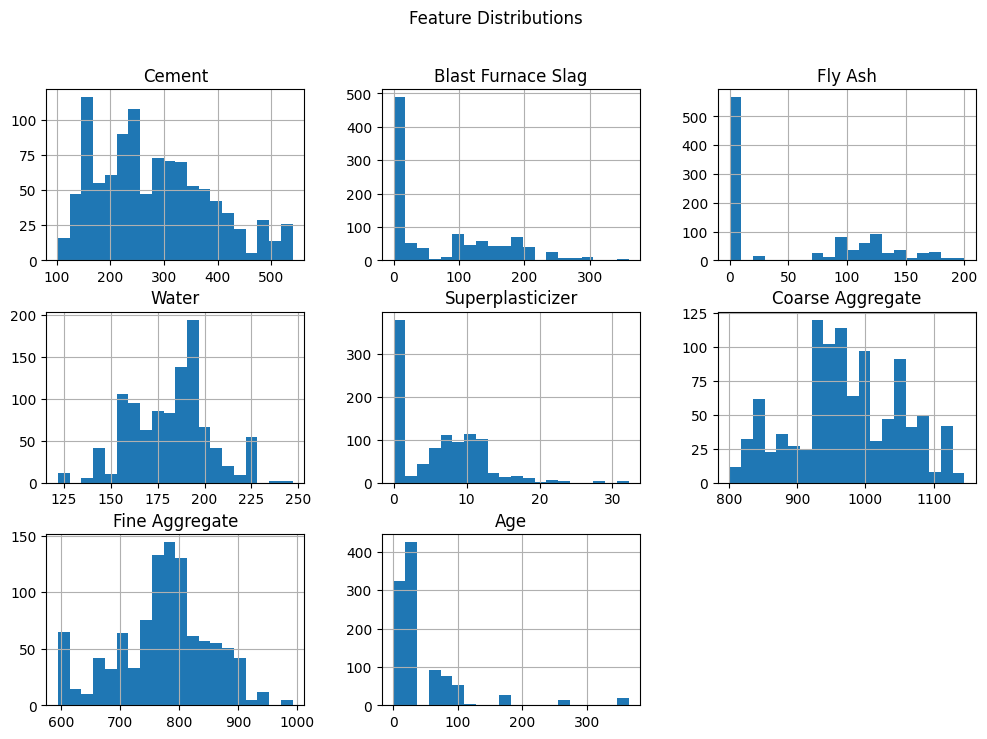

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

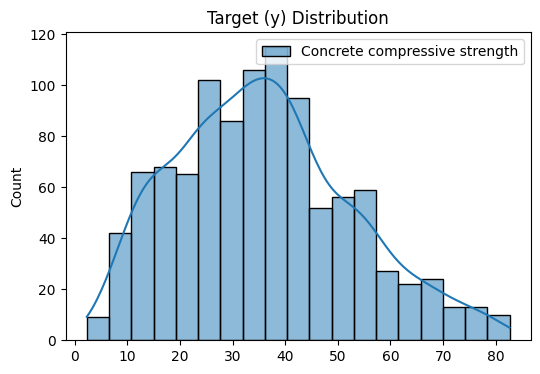

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

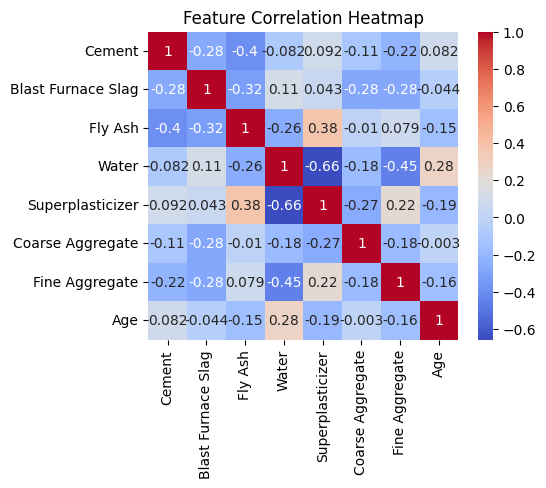

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=8, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=8)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.105039                 1.180493             1.695036   
1                  1.137009                 1.286200             1.813524   
2                  1.086786                 1.271727             2.202765   
3                  1.300856                 1.651403             1.448138   
4                  1.379571                 1.320869             1.299026   
5                  1.137703                 1.483236             1.371176   
6                  1.175841                 1.359155             1.630372   
7                  1.160789                 1.108790             1.293090   
mean               1.185449                 1.332734             1.594141   
std                0.101790                 0.170820             0.311402   

      DefaultBART_Rhat_RMSE  
0                  1.636561  
1                  1.434841  
2                  1.638842

In [8]:
rhat_df.to_csv("results/real4_Concrete_rhat.csv", index=False)

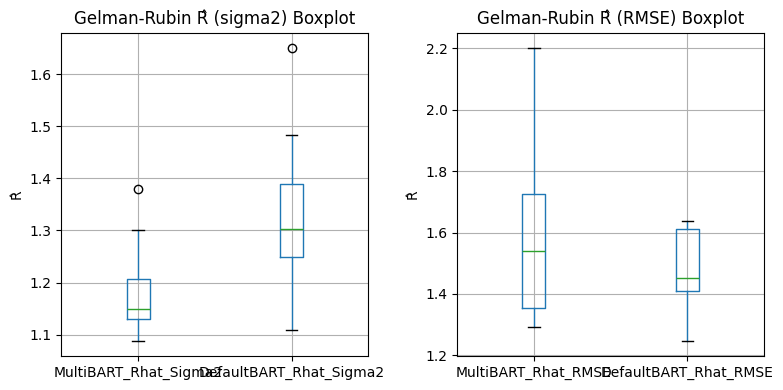

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

INFO:2025-11-25 03:34:11,783:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-25 03:34:12,150:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:2025-11-25 03:34:12,233:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to op

test_mse:
      bart_mtmh       bart        btz         rf        xgb
0     19.862233  20.659363  20.399851  25.349766  22.455559
1     21.158032  20.478065  27.050835  28.011630  22.121190
2     20.763738  22.181071  23.918584  22.352354  20.070588
3     22.366690  21.340546  19.248100  24.326422  20.167277
4     16.184314  19.720194  17.999554  24.962981  20.543163
5     18.817472  18.822306  18.519395  26.308469  19.923279
6     17.783457  21.318298  19.867298  25.112951  20.328900
7     17.185710  18.145794  17.063326  21.417550  14.329891
mean  19.265206  20.333205  20.508368  24.730265  19.992481
std    2.138634   1.361222   3.350116   2.091961   2.481962



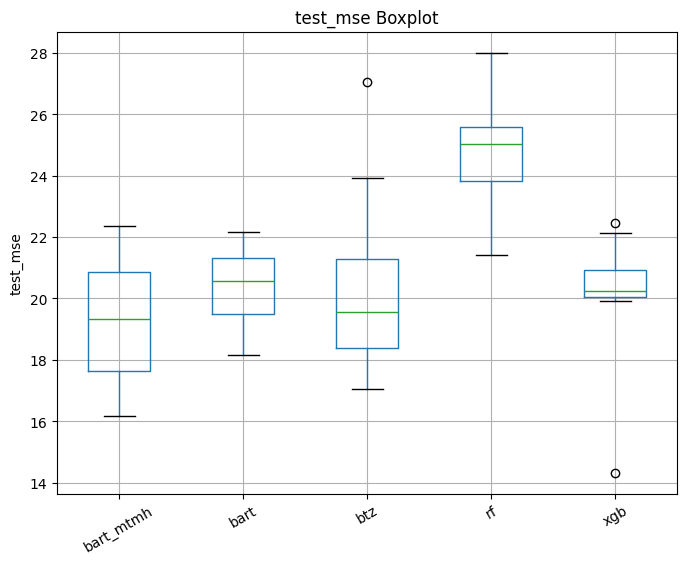

train_mse:
      bart_mtmh       bart       btz        rf       xgb
0      8.637799   8.603727  9.033507  4.499948  1.485153
1      7.874420   8.468690  7.525076  4.546035  1.495007
2      8.333101   9.394708  7.956732  4.562888  1.395256
3      7.887853   8.381962  8.305402  4.021529  1.089786
4      8.733253   9.531474  8.704111  4.354594  1.349169
5      7.994745   9.033712  8.465736  4.597305  1.337065
6      7.986502  10.715385  8.032754  4.630146  1.315198
7      8.850173  10.481071  9.538536  4.734191  1.460623
mean   8.287231   9.326341  8.445232  4.493329  1.365907
std    0.404747   0.890009  0.641853  0.219430  0.131282



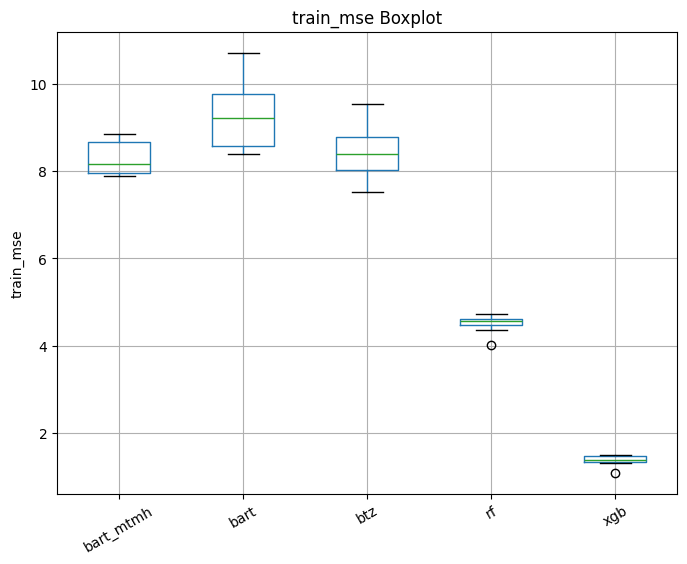

pi_length:
      bart_mtmh       bart        btz
0     14.162125  14.685041  16.727362
1     14.684048  14.293517  16.012749
2     14.662208  15.000338  16.662840
3     13.498953  14.203460  16.476076
4     15.208361  15.359942  16.617077
5     14.107788  14.797717  16.336832
6     14.431385  14.773965  16.601475
7     15.268679  15.597135  17.158665
mean  14.502943  14.838889  16.574135
std    0.588891   0.478581   0.328785



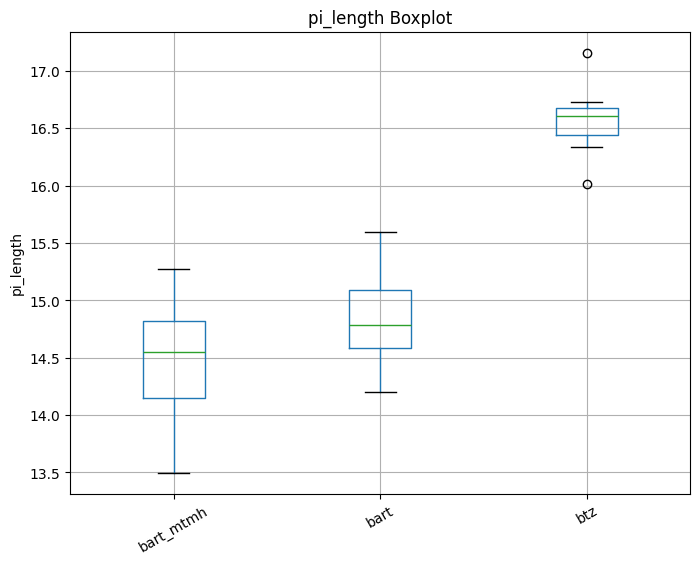

coverage:
      bart_mtmh      bart       btz
0      0.903101  0.922481  0.941860
1      0.914729  0.910853  0.899225
2      0.934109  0.918605  0.953488
3      0.891473  0.914729  0.941860
4      0.941860  0.937984  0.957364
5      0.922481  0.930233  0.941860
6      0.922481  0.895349  0.934109
7      0.934109  0.918605  0.957364
mean   0.920543  0.918605  0.940891
std    0.016958  0.012771  0.018846



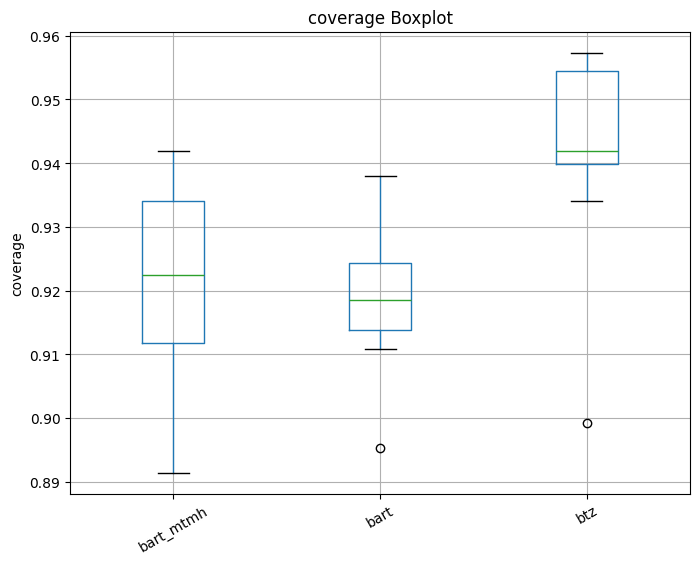

train_time:
       bart_mtmh       bart        btz        rf       xgb
0     151.904858  22.801904  65.486462  0.655542  0.167381
1     152.249794  22.915130  66.263073  0.503465  0.152406
2     152.350578  22.719899  65.616834  0.515032  0.190545
3     153.424400  22.871624  66.332969  0.444127  0.136853
4     153.770659  23.308771  67.437233  0.442021  0.134178
5     152.140919  23.015246  66.235751  0.468406  0.158920
6     152.829944  22.968524  66.219264  0.578993  0.142891
7     152.619639  22.894936  66.211282  0.557404  0.126775
mean  152.661349  22.937004  66.225359  0.520624  0.151244
std     0.649402   0.176164   0.585327  0.073723  0.020812



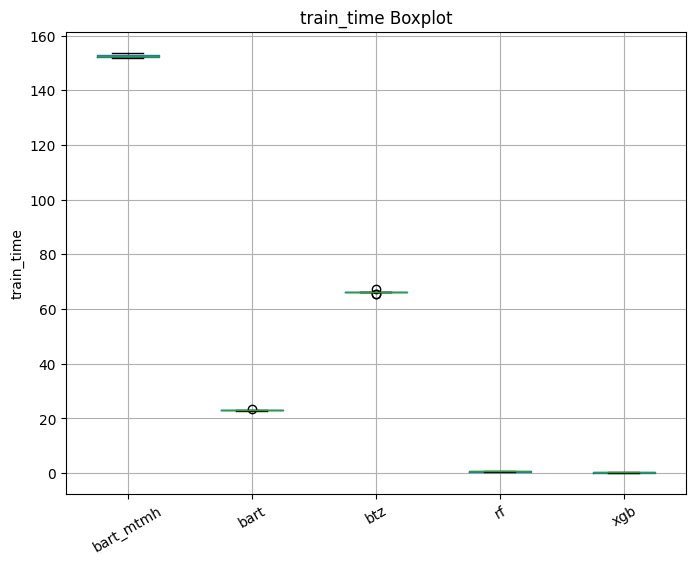

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=8, n_skip=1000, n_post=1000, n_trees=100, n_jobs=8)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real4_Concrete_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [12]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real4_Concrete_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 20, 50],
    n_runs=8, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=8
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real4_Concrete_tries.csv", index=False)

In [13]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE   Test_MSE  Coverage  Train_Time
0            1     1.352916   1.522027  20.623575  0.905523   44.729693
1            5     1.177171   1.317760  19.370718  0.917636   96.836016
2           10     1.185449   1.594141  19.290974  0.917151  151.926676
3           20     1.212747   1.337116  19.607508  0.916667  268.896894
4           50     1.203922   1.217613  18.712132  0.921027  611.531574
